In [1]:
!gdown --id '1DvrMCxzJrqKKN-rU-klk7_XikfhaCr3j'

/bin/bash: gdown: command not found


In [2]:
!unzip "pdi-2022-main.zip" -d "./"

unzip:  cannot find or open pdi-2022-main.zip, pdi-2022-main.zip.zip or pdi-2022-main.zip.ZIP.


In [1]:
import torch

from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader, random_split

import os

In [2]:
PROCESSED_IMAGES_PATH = 'data/processed'
ORIGINAL_IMAGES_PATH = 'data/original'

# Criação do Dataset

In [3]:
def get_data(path):
    paths = []
    tiles = os.listdir(path)
    for tile in range(1, len(tiles) + 1):
        images = os.listdir(f"{path}/{tile}/images")
        for image in images:
            paths.append({"image": f"{path}/{tile}/images/{image}", "label": f"{path}/{tile}/masks/{image}"})
    return paths

In [4]:
class ProcessedImagesDataset(Dataset):
    def __init__(self, img_dir):
        self.data = get_data(img_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]["image"]
        mask_path = self.data[idx]["label"]
        image, mask = read_image(image_path), read_image(mask_path, ImageReadMode.GRAY)

        return image, mask

# Treino

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_pixels = 0
    model.eval()
    dice_score = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1) # Label doesn't have a channel

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum())/((preds + y).sum() + 1e-8)

    print(f"Dice score: {dice_score/ len(loader)}")
    print(f"Got {num_correct}/{num_pixels} with accuracy {num_correct*100/num_pixels:.2f}")

In [6]:
from unet import UNet
import torch.optim as optim

In [10]:

def train_fn(loader: DataLoader, model: torch.nn.Module, optimizer: optim.Optimizer, loss_fn, scaler, epochs):
    for epoch in range(epochs):
        model.train()

        batch_loss = 0

        for batch_idx, (data, targets) in enumerate(loader):
            data = data.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.float32)

            assert data.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {data.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

            # forward
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            # backward
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            batch_loss += loss.item()
        print (f'Epoch [{epoch+1}/{epochs}], Loss: {batch_loss:.4f}')

# Teste

In [13]:
def main():
    torch.cuda.empty_cache()
    model = UNet(3, 1).to(device=device)
    dataset = ProcessedImagesDataset(PROCESSED_IMAGES_PATH)
    train_data, test_data = random_split(dataset, [50, 22])
    dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
    optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
    loss_fn = nn.BCEWithLogitsLoss()
    grad_scaler = torch.cuda.amp.GradScaler()
    epochs = 10
    try:
        train_fn(dataloader, model, optimizer, loss_fn, grad_scaler, epochs)
    except KeyboardInterrupt:
        torch.save(model.state_dict(), 'INTERRUPTED.pth')
    torch.save(model.state_dict(), 'model.pth')
    return model
predictor = main()

Epoch [1/10], Loss: -151678.6807
Epoch [2/10], Loss: -990355.3747
Epoch [3/10], Loss: -2337089.2349
Epoch [4/10], Loss: -3508831.0022
Epoch [5/10], Loss: -4982051.4751
Epoch [6/10], Loss: -6694012.1646
Epoch [7/10], Loss: -9926091.8564
Epoch [8/10], Loss: -13240439.1667
Epoch [9/10], Loss: -15851762.3220
Epoch [10/10], Loss: -19395755.5166


In [7]:
ds = ProcessedImagesDataset(PROCESSED_IMAGES_PATH)
print(ds[0][0].shape)

torch.Size([3, 256, 256])


In [8]:
image = torch.reshape(ds[0][0], (1, 3, 256, 256)).to(device, dtype=torch.float32)
image.shape

torch.Size([1, 3, 256, 256])

In [14]:
import matplotlib.pyplot as plt
import numpy as np

[[0.1748391  0.26816243 0.28170678 ... 0.19484171 0.16776124 0.12641488]
 [0.2534455  0.4068244  0.41699365 ... 0.26865417 0.22978316 0.16241205]
 [0.28608567 0.4501809  0.4313759  ... 0.26810268 0.23389491 0.16669525]
 ...
 [0.11004706 0.12140052 0.07458229 ... 0.7967183  0.8124645  0.6150861 ]
 [0.115909   0.13524736 0.09145052 ... 0.6974795  0.6625122  0.49037853]
 [0.095373   0.1079872  0.08282312 ... 0.446599   0.40898624 0.30473235]]


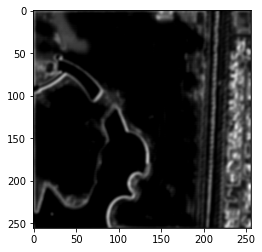

In [29]:
with torch.no_grad():
    predictor = UNet(3, 1).cuda()
    predictor.load_state_dict(torch.load("model.pth"))
    predictor.eval()
    predictions = predictor(image)[0].cpu()
    predictions = np.transpose(predictions, axes=[1, 2, 0])
    predictions = np.array(predictions.reshape(predictions.shape[0], predictions.shape[1]))
    predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
    plt.imshow(predictions, cmap="gray")